In [2]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import glob

## Q1

The functions to read the template and the event files. Note that I am only reading the plus polarisation over here. 

In [3]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    tp=template[0]
    return tp
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

The function which will smooth the noise model using a gaussian kernel. The npix (or sigma) parameter sets how the smoothening affects the lines and the thickness of the noise model.

In [4]:
def smooth_gauss(vec, npix):
    x = np.fft.fftfreq(len(vec))*len(vec)
    kernel = np.exp(-0.5*x**2/npix**2)
    kernel = kernel/kernel.sum()
    kft = np.fft.rfft(kernel)
    vft = np.fft.rfft(vec)
    return np.fft.irfft(kft*vft)

Reading in the event files and templates

In [5]:
fnames = ['./GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5', 
          './GW150914/L-L1_LOSC_4_V2-1126259446-32.hdf5',
          './LVT151012/H-H1_LOSC_4_V2-1128678884-32.hdf5',
          './LVT151012/L-L1_LOSC_4_V2-1128678884-32.hdf5',
          './GW151226/H-H1_LOSC_4_V2-1135136334-32.hdf5',
          './GW151226/L-L1_LOSC_4_V2-1135136334-32.hdf5',
          './GW170104/H-H1_LOSC_4_V1-1167559920-32.hdf5',
          './GW170104/L-L1_LOSC_4_V1-1167559920-32.hdf5']
template_name = ['./GW150914/GW150914_4_template.hdf5',
                 './LVT151012/LVT151012_4_template.hdf5',
                 './GW151226/GW151226_4_template.hdf5',
                 './GW170104/GW170104_4_template.hdf5']
events = ['GW150914','LVT151012', 'GW151226', 'GW170104']

The window function. As suggested, the window function is flat in the middle and goes to 0 at the end so as to make sure the signal strength in the middle of the data is not reduced. 

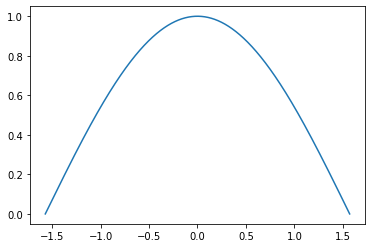

In [6]:
x=np.linspace(-np.pi/2,np.pi/2,131072)
win=np.cos(x)
plt.plot(x, win)

Text(0.5, 1.0, 'The window function')

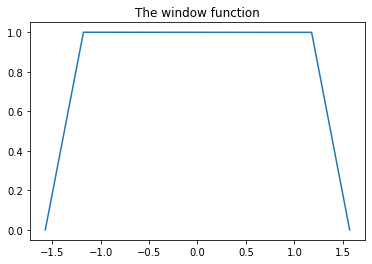

In [7]:
m1 = 1/(x[16383] - x[0])
c1 = -m1*x[0]
part1 = x[0:16383]*m1 + c1
win[0:16383] = part1.copy()
m2 = 1/(x[114687] - x[131071])
c2 = -m2*x[131071]
part2 = x[114687:131071]*m2 + c2
win[114687:131071] = part2.copy()
win[16383:114687] = 1
plt.plot(x, win)
#plt.xlim(x[0], x[4000])
plt.title("The window function")

## a) 

To get the noise model, I do the following (same procedure is followed for all events):
First I take the fourier transfrom of the strain multiplied by the window function. The window function makes the strain go to zero at the edges, preventing spectral leakage. Since the signal would be a very small part of the strain, and since we are considering the noise to be stationary, taking the fft$^2$ of the windowed strain gives the power spectrum. Then, I smoothen the power spectrum by convolving it with a gaussian kernel.It is very important to select the sigma of the gaussian such that the power spectrum I obtain is consistent with the theoritical power spectrum given by the LIGO collaboration: the thickness of the power spectrum should be less and the lines in the power spectrum should not be too diminished in magnitude. I choose 5 as the sigma taking these factors into consideration.

## b) 

I use the matched filter to find the amplitude of the template at each point in the strain.

## c)

To get the analytical noise for each detector, I use sqrt((A 𝑇 N −1 A) −1 ). The signal strength is calculated by the taking the maximum of the absolute amplitude obtained from the matched filter. The SNR is the signal strength divided by the noise. The SNR for H+L is the sum in quadrature of both SNRs

## d)

The scatter in the matched filter is obtained by getting the std of the matched filter amplitude away from where the maximum aplitude is. I would say that the SNR calculated from the scatter in the MF is pretty close to the SNR calculated analytically (as can be seeb below). 

## e)

First I get the power spectrum of the template. The frequency from each event where half the weight comes from above that frequency and half below is obtained from the smoothed power spectrum of the template and the events. For each frequency, I sum the power in all frequencies before that frequency and obtain the frequency for which that sum is half of the total power (which is the power summed for all frequencies)

## f)

First I get the time of arrival of the gravitational wave from the Hanford and the Livingston detectors by getting the time for which the absoulute value of the matched filter amplitude is maximum. I get the uncertainty in the time of arrival by looking at the spread of the maximum amplitude peak: getting the FWHM of the peak. How I obtain the theta is explained with the help of a drawing in the report. Explanation of uncertainty in theta is also explained in the report. 

All parts of the question for all events:

***Working on event GW150914***
PART A
Time for which strain is observed at Hanford for event GW150914 is 32.0
Time for which strain is observed at Livingston for event GW150914 is 32.0
PART C
Noise at Hanford is 5.994711163597431e-05, noise at Livingston is 6.901456685632569e-05
SNR at Hanford is 18.572385958497613, SNR at Livingston is 13.827758142816116 and total SNR is 23.154706118791847
PART D
SNR from scatter in MF = 19.52036171022165 and SNR from analytical calculation = 18.572385958497613 for Hanford
SNR from scatter in MF = 14.406726591574264 and SNR from analytical calculation = 13.827758142816116 for Livingston
PART E
Frequency where half the weight comes from above that frequency and half below:
For the template: at frequency 10.75
For the Hanford event: at frequency 6.40625
For the Livingston event: at frequency 0.09375
PART F
TOA at Hanford for event GW150914 is 0.4404296875+-0.001708984375
TOA at Livingston for event GW150914 is 0.43310546875+-0.00146484375
The gravitati

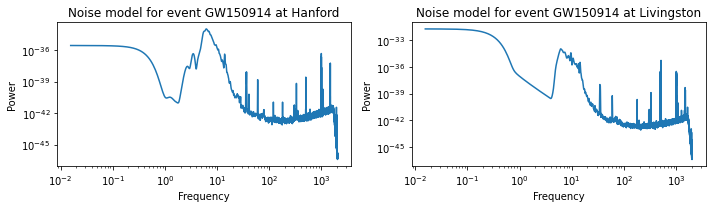

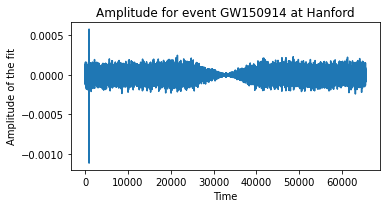

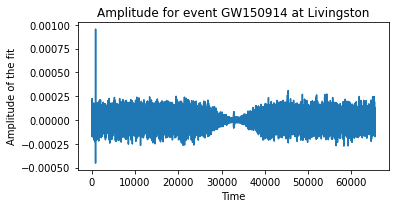

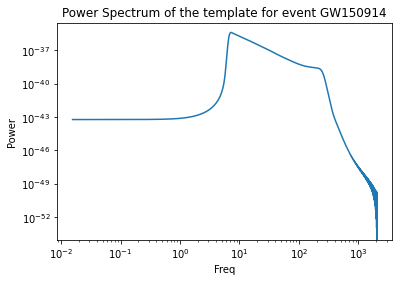

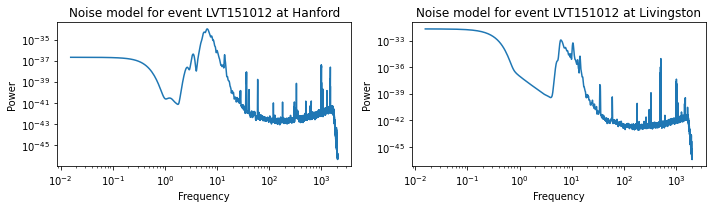

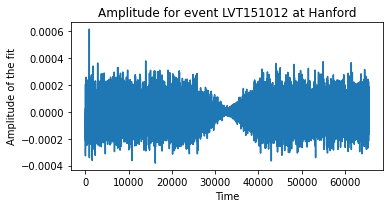

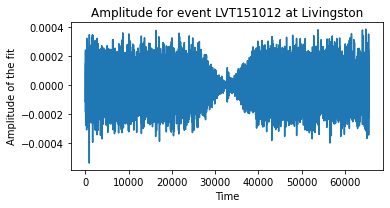

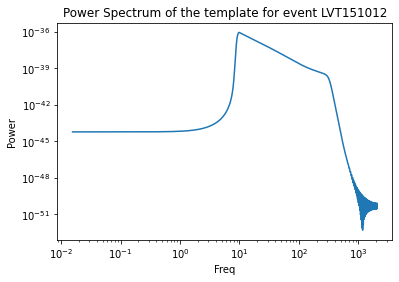

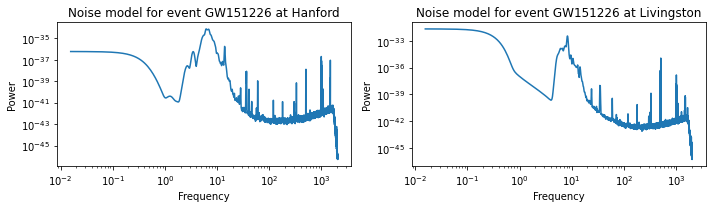

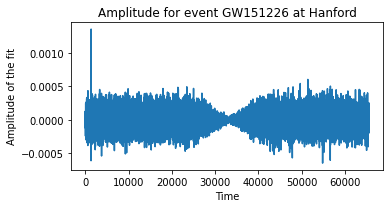

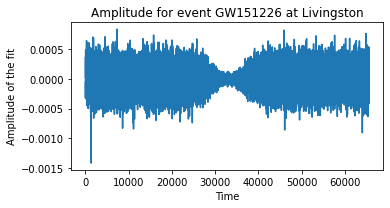

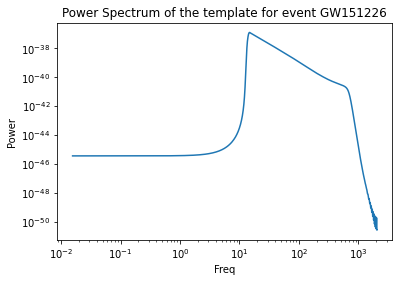

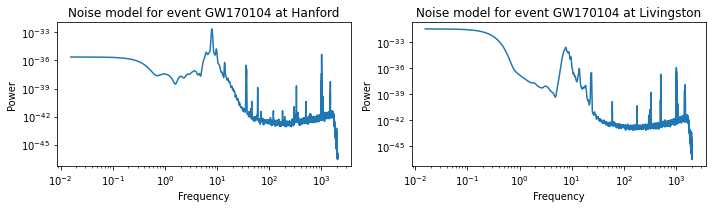

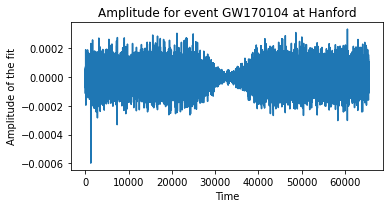

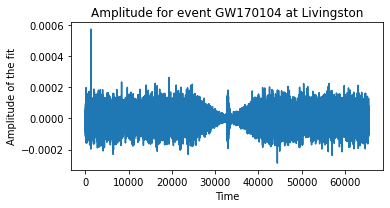

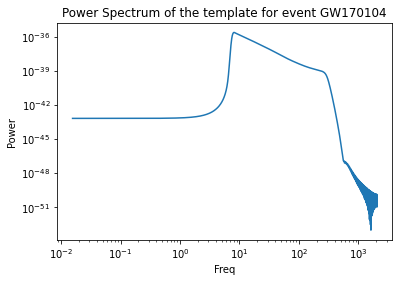

In [14]:
for i in range(4):
    print('***Working on event {}***'.format(events[i]))
    print("PART A")
    tp=read_template(template_name[i])
    strain_H,dt_H,utc_H=read_file(fnames[i*2])
    tobs_H=dt_H*len(strain_H)
    print('Time for which strain is observed at Hanford for event ' + events[i] + ' is ' + str(tobs_H))
    strain_win_H = np.fft.fft(strain_H*win)
    ps_H = np.abs(strain_win_H)**2
    ps_smooth_H = smooth_gauss(ps_H,5)
    ps_smooth_H = ps_smooth_H[:len(strain_H)//2+1]
    ps_smooth_H = ps_smooth_H/len(ps_smooth_H)
    dnu_H=1/tobs_H
    nu_H=np.arange(len(ps_smooth_H))*dnu_H
    nu_H[0]=0.5*nu_H[1]
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.loglog(nu_H, np.abs(ps_smooth_H))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.title("Noise model for event " + str(events[i]) + " at Hanford")
    plt.tight_layout()
    strain_L,dt_L,utc_L=read_file(fnames[i*2 + 1])
    tobs_L=dt_L*len(strain_L)
    print('Time for which strain is observed at Livingston for event ' + events[i] + ' is ' + str(tobs_L))
    strain_win_L = np.fft.fft(strain_L*win)
    ps_L = np.abs(strain_win_L)**2
    ps_smooth_L = smooth_gauss(ps_L,5)
    ps_smooth_L = ps_smooth_L[:len(strain_L)//2+1]
    ps_smooth_L = ps_smooth_L/len(ps_smooth_L)
    dnu_L=1/tobs_L
    nu_L=np.arange(len(ps_smooth_L))*dnu_L
    nu_L[0]=0.5*nu_L[1]
    plt.subplot(1,2,2)
    plt.loglog(nu_L, np.abs(ps_smooth_L))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.title("Noise model for event " + str(events[i]) + " at Livingston")
    plt.tight_layout()
    
    #part b
    #print("PART B")
    data_ft_H = np.fft.rfft(win*strain_H)
    data_white_ft_H = data_ft_H/np.sqrt(ps_smooth_H)
    data_white_H = np.fft.irfft(data_white_ft_H, len(data_white_ft_H))
    template_ft = np.fft.rfft(win*tp)
    template_white_ft_H = template_ft/np.sqrt(ps_smooth_H)
    template_white_H = np.fft.irfft(template_white_ft_H, len(template_white_ft_H))
    mf_rhs_H = np.fft.irfft(data_white_ft_H*np.conj(template_white_ft_H), len(data_white_ft_H))
    mf_lhs_H = template_white_H.T@template_white_H
    amp_H = mf_rhs_H/mf_lhs_H
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(amp_H)
    plt.xlabel("Time")
    plt.ylabel("Amplitude of the fit")
    plt.title("Amplitude for event " + str(events[i]) + " at Hanford")
    plt.tight_layout()
    data_ft_L = np.fft.rfft(win*strain_L)
    data_white_ft_L = data_ft_L/np.sqrt(ps_smooth_L)
    data_white_L = np.fft.irfft(data_white_ft_L, len(data_white_ft_L))
    template_ft = np.fft.rfft(win*tp)
    template_white_ft_L = template_ft/np.sqrt(ps_smooth_L)
    template_white_L = np.fft.irfft(template_white_ft_L, len(template_white_ft_L))
    mf_rhs_L = np.fft.irfft(data_white_ft_L*np.conj(template_white_ft_L), len(data_white_ft_L))
    mf_lhs_L = template_white_L.T@template_white_L
    amp_L = mf_rhs_L/mf_lhs_L
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,2)
    plt.plot(amp_L)
    plt.xlabel("Time")
    plt.ylabel("Amplitude of the fit")
    plt.title("Amplitude for event " + str(events[i]) + " at Livingston")
    plt.tight_layout()
    
    #part c
    print("PART C")
    error_H = np.sqrt(1/mf_lhs_H)
    SNR_H = np.max(np.abs(amp_H))/error_H
    error_L = np.sqrt(1/mf_lhs_L)
    SNR_L = np.max(np.abs(amp_L))/error_L
    SNR_total = np.sqrt(SNR_H**2 + SNR_L**2)
    print("Noise at Hanford is {}, noise at Livingston is {}".format(error_H, error_L))
    print("SNR at Hanford is {}, SNR at Livingston is {} and total SNR is {}".format(SNR_H, SNR_L, SNR_total))
    
    #part d
    print("PART D")
    scatter_H = np.std(amp_H[5000:])
    scatter_L = np.std(amp_L[5000:])
    SNR_scatter_H = np.max(np.abs(amp_H))/scatter_H
    SNR_scatter_L = np.max(np.abs(amp_L))/scatter_L
    print("SNR from scatter in MF = {} and SNR from analytical calculation = {} for Hanford".format(SNR_scatter_H, SNR_H))
    print("SNR from scatter in MF = {} and SNR from analytical calculation = {} for Livingston".format(SNR_scatter_L, SNR_L))
    
    #part e
    print("PART E")
    temp_win = np.fft.fft(tp*win)
    ps_temp = np.abs(temp_win)**2
    ps_smooth_temp = smooth_gauss(ps_temp,5)
    ps_smooth_temp = ps_smooth_temp[:len(tp)//2+1]
    ps_smooth_temp = ps_smooth_temp/len(ps_smooth_temp)
    plt.figure()
    plt.loglog(nu_H, ps_smooth_temp)
    plt.xlabel('Freq')
    plt.ylabel('Power')
    plt.title("Power Spectrum of the template for event {}".format(events[i]))
    total_power_temp = np.sum(ps_smooth_temp) 
    sum = 0
    for j in range(len(ps_smooth_temp)):
        sum += ps_smooth_temp[j]
        if sum > total_power_temp/2:
            break
    total_power_H = np.sum(ps_smooth_H)
    sum = 0
    for k in range(len(ps_smooth_H)):
        sum += ps_smooth_H[k]
        if sum > total_power_H/2:
            break
    total_power_L = np.sum(ps_smooth_L)
    sum = 0
    for l in range(len(ps_smooth_L)):
        sum += ps_smooth_L[l]
        if sum > total_power_L/2:
            break
    print("Frequency where half the weight comes from above that frequency and half below:")
    print("For the template: at frequency {}".format(nu_H[j]))
    print("For the Hanford event: at frequency {}".format(nu_H[k]))
    print("For the Livingston event: at frequency {}".format(nu_H[l]))
    
    #part f
    print("PART F")
    toa_H = 0
    toa_L = 0
    index_H = 0 #index where the amplitude is maximum
    index_L = 0 #index where the amplitude is maximum
    t_obs_H = dt_H*len(strain_H)
    time_H = np.linspace(0, t_obs_H, len(amp_H))
    t_obs_L = dt_L*len(strain_L)
    time_L = np.linspace(0, t_obs_L, len(amp_L))
    amp_max_H = np.max(np.abs(amp_H))
    amp_max_L = np.max(np.abs(amp_L))
    for j in range(amp_H.size):
        if np.abs(amp_H[j]) == amp_max_H:
            toa_H = time_H[j]
            index_H = j
            break
    left_index = 0
    left_amp = amp_max_H
    j = index_H
    while left_amp > amp_max_H/2:
        j =j - 1
        left_amp = np.abs(amp_H[j])
    left_index = j
    right_index = 0
    right_amp = amp_max_H
    j = index_H
    while right_amp > amp_max_H/2:
        j = j + 1
        right_amp = np.abs(amp_H[j])
    right_index = j
    delta_t_H = np.abs(time_H[right_index] - time_H[left_index])/2 #uncertainty in the time of max amplitude
    for j in range(amp_L.size):
        if np.abs(amp_L[j]) == amp_max_L:
            toa_L = time_L[j]
            index_L = j
            break
    left_index = 0
    left_amp = amp_max_L
    j = index_L
    while left_amp > amp_max_L/2:
        j = j - 1
        left_amp = np.abs(amp_L[j])
    left_index = j
    right_index = 0
    right_amp = amp_max_L
    j = index_L
    while right_amp > amp_max_L/2:
        j = j + 1
        right_amp = np.abs(amp_L[j])
    right_index = j
    delta_t_L = np.abs(time_L[right_index] - time_H[left_index])/2 #uncertainty in the time of max amplitude
    print("TOA at Hanford for event {} is {}+-{}".format(events[i], toa_H, delta_t_H))
    print("TOA at Livingston for event {} is {}+-{}".format(events[i], toa_L, delta_t_L))
    delta_t = np.abs(toa_H - toa_L)
    delta_t_uncert = np.sqrt(delta_t_H**2 + delta_t_L**2)
    sin_theta = (3*10**8)*delta_t/(3030*10**3)
    sin_theta_max = (3*10**8)*(delta_t + delta_t_uncert)/(3030*10**3)
    theta = np.arcsin(sin_theta)
    delta_theta = np.arcsin(sin_theta_max) - theta
    theta = np.rad2deg(theta)
    delta_theta = np.rad2deg(delta_theta)
    print('The gravitational wave can be localised to an angle {} +- {} degrees away from the normal'. format(theta, delta_theta))

## Q2) 

The A$_{eff}$ is the beam pattern integrated over the radius of the dish (I am considering the radius of the dish to be 1 over here). A is just $\pi R^2$. A$_{eff}$/A is multiplied by the fraction of the beam that ends up on the primary. Since the gaussian beam extends to infinity, the fraction is just the ratio of the gaussian integrated from 0 to R, and the gaussian integrated from 0 to infinity. Plotting this against different values of sigma of the gaussian to see which sigma maximises the signal strength (the mathematical derivation of the signal strength equation is shown in the report)

/home/vishwangi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'signal strength')

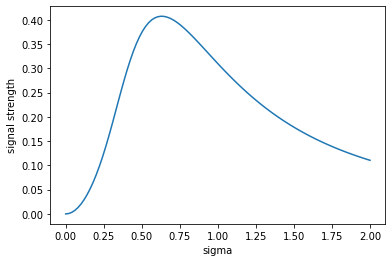

In [65]:
sigma = np.linspace(0, 2, 100)
signal_strength = 2*sigma**2*(1 - np.exp(-1/(2*sigma**2)))**2
plt.plot(sigma, signal_strength)
plt.xlabel("sigma")
plt.ylabel("signal strength")

Getting the sigma that maximises the signal strength

In [66]:
max_feed_strength = np.max(signal_strength)
max_sigma = 0
for i in range(len(sigma)):
    if signal_strength[i] == max_feed_strength:
        max_sigma = sigma[i]
        break
print("The sigma that maximises the signal strength is {}".format(max_sigma))

The sigma that maximises the signal strength is 0.6262626262626263


Getting A$_{eff}$/A at that sigma

In [68]:
Aeff_A = 2*max_sigma**2*(1 - np.exp(-1/(2*max_sigma**2)))
Aeff_A
print("A_eff/A at the peak is {}".format(Aeff_A))

A_eff/A at the peak is 0.5651871618183043


Getting the fraction of the beam that ends up off the primary

In [69]:
on_dish = (1 - np.exp(-1/(2*max_sigma**2)))
off_dish = 1 - on_dish
print("Fraction of the beam which ends up off the primary is {}".format(off_dish))

Fraction of the beam which ends up off the primary is 0.2794745872813216
